In [1]:
# Change directory level to be 1 level up
import os
def dir_level(num, path):
    if num == 1:
        return os.path.dirname(path)
    else:
        return os.path.dirname(dir_level(num-1,path))

current_dir = os.getcwd()
home_dir = dir_level(1,os.getcwd())
# print(current_dir)    
# print(home_dir)
os.chdir(home_dir)
# print(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap  # Used for matplotlib text wrapping
from src.api_data_gov import download_collection

In [3]:
# Get the ACRA information which is at collection 2
acra = download_collection(collection_id=2, chk='Yes', combcsv='No',
                           indcsv='Yes', csvdir='data')
print(acra)

Collection 2 contains 27 no(s) of dataset.
Checked 1 out of 27 datasets.
Checked 2 out of 27 datasets.
Checked 3 out of 27 datasets.
Checked 4 out of 27 datasets.
Checked 5 out of 27 datasets.
Checked 6 out of 27 datasets.
Checked 7 out of 27 datasets.
Checked 8 out of 27 datasets.
Checked 9 out of 27 datasets.
Checked 10 out of 27 datasets.
Checked 11 out of 27 datasets.
Checked 12 out of 27 datasets.
Checked 13 out of 27 datasets.
Checked 14 out of 27 datasets.
Checked 15 out of 27 datasets.
Checked 16 out of 27 datasets.
Checked 17 out of 27 datasets.
Checked 18 out of 27 datasets.
Checked 19 out of 27 datasets.
Checked 20 out of 27 datasets.
Checked 21 out of 27 datasets.
Checked 22 out of 27 datasets.
Checked 23 out of 27 datasets.
Checked 24 out of 27 datasets.
Checked 25 out of 27 datasets.
Checked 26 out of 27 datasets.
Checked 27 out of 27 datasets.
4 out of 27 datasets missing.
Start of Missing Dataset 1 out of 4
There are a total of 22432 rows in this dataset
Processed 1000 

Processed 75000 / 78911 rows.
Processed 76000 / 78911 rows.
Processed 77000 / 78911 rows.
Processed 78000 / 78911 rows.
Processed 78911 / 78911 rows.
data/2024-03-07 ACRA Information on Corporate Entities ('E').csv downloaded
data/2024-03-07 ACRA Information on Corporate Entities ('E')_dtype.json created
End of Missing Dataset 4 out of 4
           _id         uen issuance_agency_id  \
0            1   00012700X               ACRA   
1            2   00021600C               ACRA   
2            3   00036800L               ACRA   
3            4   00043000E               ACRA   
4            5   00063900A               ACRA   
...        ...         ...                ...   
1919433  78907  T24LL0151A               ACRA   
1919434  78908  T24LL0177J               ACRA   
1919435  78909  T24LP0003G               ACRA   
1919436  78910  T24LP0011J               ACRA   
1919437  78911  T24LP0012E               ACRA   

                                               entity_name  \
0        

In [4]:
acracollist = ['uen','entity_name','postal_code','entity_type_description', 'business_constitution_description',
               'primary_ssic_code','primary_ssic_description','secondary_ssic_code','secondary_ssic_description',
               'entity_status_description','registration_incorporation_date']
acra_df = acra.loc[:, acracollist]

# Clean up the 'na' in the column, and convert the date
acra_df.replace('na', np.nan, inplace=True)
acra_df['registration_incorporation_date'] = pd.to_datetime(acra_df['registration_incorporation_date'], errors='coerce')

# Get total number of months / years since registration
ref_date = pd.Timestamp('2024-03-01')
acra_df['months_live'] = ((ref_date.year-acra_df['registration_incorporation_date'].dt.year)*12+
                          (ref_date.month-acra_df['registration_incorporation_date'].dt.month))
acra_df['years_live'] = ref_date.year-acra_df['registration_incorporation_date'].dt.year
acra_df['year_incorporated'] = acra_df['registration_incorporation_date'].dt.year

# Do binning based on dates
# Define bucket boundaries in years
year_buckets = {
    'Less than 2 years': 2,
    '2 - 5 Years': 5,
    '6 - 10 Years': 10,
    '10 - 20 Years': 20,
    'More than 20 Years': 1000
}

# Categorize the year data into buckets
acra_df['years_bucket'] = pd.cut((ref_date - acra_df['registration_incorporation_date']).dt.days / 365, 
                      bins=[0] + list(year_buckets.values()), 
                      labels=list(year_buckets.keys()), 
                      right=False)

# Categorize entity status into buckets
# 3 buckets of Live, No Status, Others
acra_df['entity_status_bucket'] = acra_df['entity_status_description']
acra_df['entity_status_bucket'] = acra_df['entity_status_bucket'].fillna('No Status')
live_list = ['Live Company', 'Live', 'Live (Receiver or Receiver and Manager appointed)', 'Converted To LLP', 'Amalgamated']
acra_df['entity_status_bucket'] = acra_df['entity_status_bucket'].replace({variation: 'Live' for variation in live_list})
acra_df.loc[~acra_df['entity_status_bucket'].isin(['Live','No Status']), 'entity_status_bucket'] = 'Others'

acra_df['registration_incorporation_date'] = acra_df['registration_incorporation_date'].dt.strftime('%Y-%m-%d')
acra_df = acra_df.add_prefix('acra_')

# Sort the whole dataframe by entity_name alphabetically
acra_df = acra_df.sort_values(by='acra_entity_name', ascending=True)
print(acra_df)

          acra_uen                 acra_entity_name acra_postal_code  \
416542   53278504E                            !3MED           820296   
416904   53311591D                     !DEABUNDANCE           398453   
404817  201542182E  !DEAS CREATIVE STUDIO PTE. LTD.           369977   
409226  202334903D             !NTANGIBLE PTE. LTD.           101070   
411300   52892494W                    !WEB A-GO-GO!           596282   
...            ...                              ...              ...   
410531   51387100D        `THE FLINT HILLS' TRADERS           328958   
420019  T14LL1179L              {FLIPPINGNOTES} LLP           791435   
414190   53121559L                     | S | FACTOR           438795   
412969   53030403A                   ~ISMS PICTURES           141040   
503687   53347159A                              NaN           460003   

       acra_entity_type_description acra_business_constitution_description  \
416542                     Business                      

# Number of Years Businesses are Live

In [5]:
entity_status = acra_df['acra_entity_status_description'].fillna('No Status').value_counts()
print(entity_status)

Struck Off                                                      425661
Live Company                                                    413559
No Status                                                       364312
Cancelled                                                       302067
Live                                                            157721
Cancelled (Non-Renewal)                                         102382
Ceased Registration                                              88788
Dissolved - Members' Voluntary Winding Up                        33598
Gazetted To Be Struck Off                                         7541
Dissolved - Compulsory Winding Up (Insolvency)                    5914
Converted To LLP                                                  3977
Dissolved - Creditors' Voluntary Winding Up                       3511
Amalgamated                                                       2167
Registration expired and has not been renewed                     1911
Cancel

In [6]:
# Calculate counts for each category
stacked_data = acra_df.groupby(['acra_year_incorporated', 'acra_entity_status_bucket']).size().unstack(fill_value=0)
print(stacked_data)
print()
stacked_data_filtered = stacked_data[stacked_data.index >= 1990].sort_index(ascending=False)
new_stacked_data = stacked_data_filtered.copy()
new_stacked_data['Total'] = new_stacked_data['Live'] + new_stacked_data['No Status'] + new_stacked_data['Others']
new_stacked_data['Not Live %'] = 100 - (new_stacked_data['Live'] / new_stacked_data['Total'] * 100)
print(new_stacked_data)

acra_entity_status_bucket   Live  No Status  Others
acra_year_incorporated                             
1881                           0          1       0
1887                           2          1       1
1889                           0          0       6
1890                           1          0       1
1891                           0          0       6
...                          ...        ...     ...
2020                       38753        122   24605
2021                       48372         90   16690
2022                       53362         91   10052
2023                       67280         97    2789
2024                        8095         11      66

[133 rows x 3 columns]

acra_entity_status_bucket   Live  No Status  Others  Total  Not Live %
acra_year_incorporated                                                
2024                        8095         11      66   8172    0.942242
2023                       67280         97    2789  70166    4.113103
2022           

<Figure size 1200x600 with 0 Axes>

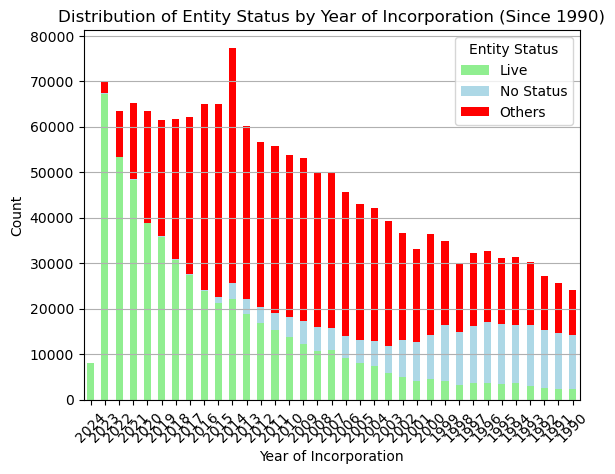

In [7]:
# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
stacked_data_filtered.plot(kind='bar', stacked=True, color=['lightgreen', 'lightblue', 'red'])
plt.title('Distribution of Entity Status by Year of Incorporation (Since 1990)')
plt.xlabel('Year of Incorporation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Entity Status')
plt.show()

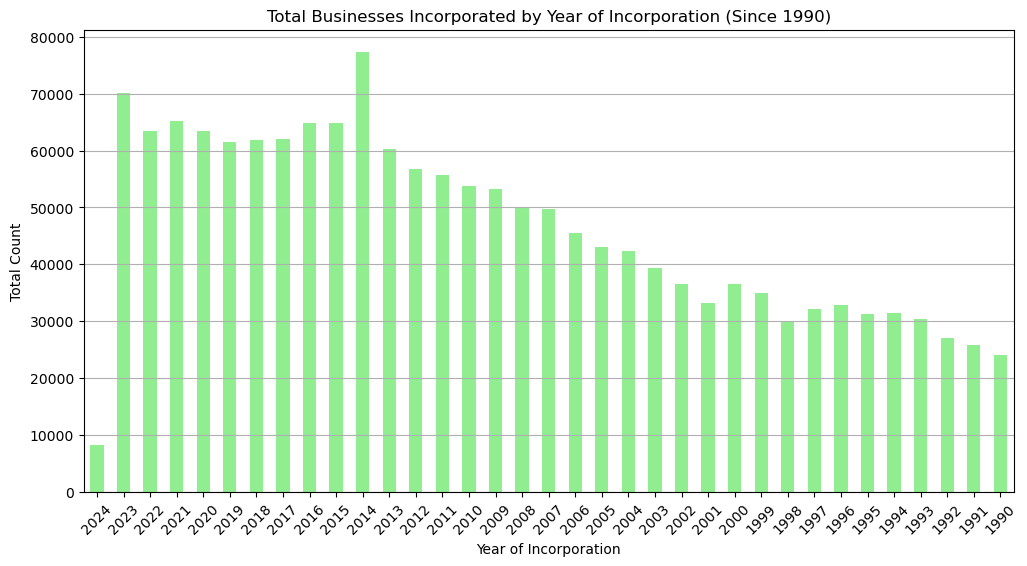

In [8]:
# Plotting the total counts for each year of incorporation
plt.figure(figsize=(12, 6))
new_stacked_data['Total'].plot(kind='bar', color='lightgreen')
plt.title('Total Businesses Incorporated by Year of Incorporation (Since 1990)')
plt.xlabel('Year of Incorporation')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

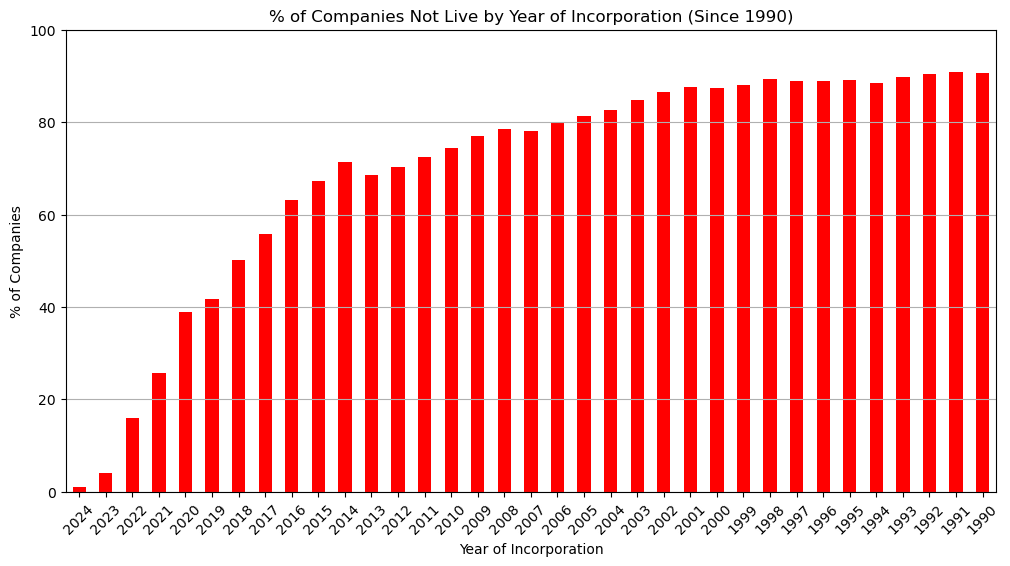

In [9]:
# Plotting the total counts for each year of incorporation
plt.figure(figsize=(12, 6))
new_stacked_data['Not Live %'].plot(kind='bar', color='red')
plt.title('% of Companies Not Live by Year of Incorporation (Since 1990)')
plt.xlabel('Year of Incorporation')
plt.ylabel('% of Companies')
plt.ylim(0,100)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# SSIC Distribution
## HDB DRC SSIC obtained from another Jupyter Notebook

In [10]:
primary_ssic_description = acra_df['acra_primary_ssic_description'].fillna('No SSIC Description').value_counts()
print(primary_ssic_description)

WHOLESALE TRADE OF A VARIETY OF GOODS WITHOUT A DOMINANT PRODUCT                  198880
MANAGEMENT CONSULTANCY SERVICES                                                    94813
OTHER HOLDING COMPANIES                                                            90053
DEVELOPMENT OF SOFTWARE AND APPLICATIONS (EXCEPT GAMES AND CYBERSECURITY)          38099
RETAIL SALE OF CLOTHING FOR ADULTS                                                 37100
                                                                                   ...  
MANUFACTURE OF ATTAP AND ATTAP PRODUCTS                                                1
PRIVATE DEBT FUNDS                                                                     1
PRODUCTION OF PREFABRICATED PREFINISHED VOLUMETRIC CONSTRUCTION (PPVC) MODULES         1
POLICE                                                                                 1
DUCK FARMS                                                                             1
Name: acra_primary_ss

In [11]:
# SSIC list from HDB DRC >= 20
pri_more_20 = ['RENOVATION CONTRACTORS', 'INTERIOR DESIGN SERVICES',
               'GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)',
               'BUILDING CONSTRUCTION N.E.C.',
               'MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)',
               'GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)',
               'MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRAMES, GRILLES AND GRATINGS',
               'INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS']

In [12]:
# SSIC list from HDB DRC < 20
pri_less_20 = ['WHOLESALE TRADE OF A VARIETY OF GOODS WITHOUT A DOMINANT PRODUCT',
               'ELECTRICAL WORKS', 'GENERAL BUILDING ENGINEERING DESIGN AND CONSULTANCY SERVICES',
               'TILE SETTING AND PLASTERING',
               'MANUFACTURE OF WOODEN WINDOW, DOOR AND OTHER MILLWORK, EXCEPT PREFABRICATED WOODEN BUILDING STRUCTURES',
               'INSTALLATION OF INDUSTRIAL MACHINERY AND EQUIPMENT, MECHANICAL ENGINEERING WORKS',
               'MANUFACTURE OF WINDOW AND DOOR SCREENS AND SHADES',
               'BUILDING COMPLETION AND FINISHING N.E.C.',
               'INSTALLATION OF PLUMBING, HEATING (NON-ELECTRIC) AND AIR-CONDITIONING SYSTEMS',
               'MANUFACTURE OF FURNITURE N.E.C.', 'OTHER CONSTRUCTION INSTALLATION N.E.C.',
               'MANUFACTURE OF SIGNS AND ADVERTISING DISPLAYS (INCLUDING NEON-LIGHTING)',
               'WRECKING AND DEMOLITION WORKS',
               'GLASS AND GLAZING WORKS (INCLUDING MIRROR AND SHOWER SCREEN INSTALLATION)',
               'OTHER SPECIALISED CONSTRUCTION AND RELATED ACTIVITIES N.E.C. (EXCLUDING ONLINE MARKETPLACES)',
               'PAINTING AND DECORATING', 'MANUFACTURE OF FURNITURE AND FIXTURES PRIMARILY OF METAL',
               'JOINERY AND OTHER WOODWORKS (EG LAMINATED OR PARQUET FLOORING)', 'ART AND GRAPHIC DESIGN SERVICES',
               'MANAGEMENT CONSULTANCY SERVICES',
               'RETAIL SALE OF HARDWARE, PAINT AND GLASS N.E.C. (EG WOOD, GLASS, SANITARY WARE, DO-IT-YOURSELF MATERIALS)',
               'FURNITURE DESIGN SERVICES', 'IRON AND STEEL FOUNDRIES',
               'LANDSCAPE DESIGN AND LANDSCAPE ARCHITECTURE',
               'WHOLESALE OF FURNITURE (INCLUDING MATTRESSES, CUSHIONS)',
               'RESIDENTIAL (OTHER THAN TOWN COUNCILS), COMMERCIAL AND INDUSTRIAL REAL ESTATE MANAGEMENT',
               'ENGINEERING DESIGN AND CONSULTANCY ACTIVITIES N.E.C.',
               'CONSTRUCTION OF OTHER CIVIL ENGINEERING PROJECTS N.E.C. (EG PLAYGROUND SYSTEMS)',
               'CUTTING, SHAPING AND FINISHING OF STONE (INCLUDING TOMB-STONES AND FURNITURE OF STONE OR MARBLE)',
               'OTHER BUSINESS SUPPORT SERVICE ACTIVITIES (E.G. ADMINISTRATION OF LOYALTY PROGRAMMES)',
               'INDUSTRIAL DESIGN ACTIVITIES N.E.C.',
               'MANUFACTURE OF HOUSEHOLD AND KITCHEN WOODEN WARE EXCEPT WOODEN FOOTWEAR',
               'STRUCTURAL REPAIR CONTRACTORS', 'REAL ESTATE AGENCIES AND VALUATION SERVICES',
               'WHOLESALE OF FURNISHINGS (INCLUDING CURTAINS, CARPETS, WALLPAPER)',
               'WHOLESALE OF CONSTRUCTION MATERIALS, HARDWARE, PLUMBING AND HEATING EQUIPMENT AND SUPPLIES N.E.C. (EG CEMENT, SAND)',
               'RETAIL SALE OF HOUSEHOLD ELECTRICAL APPLIANCES AND EQUIPMENT (EG VACUUM CLEANERS, WASHING MACHINES, REFRIGERATORS)',
               'OTHER PERSONAL SERVICE ACTIVITIES N.E.C. (EXCLUDING ONLINE MARKETPLACES)',
               'WHOLESALE OF FURNITURE, HOME FURNISHINGS AND OTHER HOUSEHOLD EQUIPMENT N.E.C.',
               'MANUFACTURE OF STRUCTURAL METAL PRODUCTS N.E.C. (EG METAL SECTIONS, CORRUGATED SHEETS)',
               'TRAINING COURSES N.E.C.', 'ARCHITECTURAL SERVICES', 'RETAIL SALE OF FURNITURE (INCLUDING MATTRESSES, CUSHIONS)',
               'MANUFACTURE AND REPAIR OF MACHINERY AND MACHINE-TOOLS - METAL CUTTING TYPES (EG LATHES, MILLING MACHINES, SHAPING MACHINES)',
               'MANAGEMENT CONSULTANCY SERVICES N.E.C.', 'MARINE CONSTRUCTION (EG HARBOURS, PIERS, DOCKS, WHARVES)',
               'OTHER MANUFACTURING INDUSTRIES N.E.C.', 'BRICK LAYING, STONE SETTING AND CEMENT WORKS',
               'INSTALLATION OF THERMAL AND SOUND INSULATION (INCLUDING SOLAR CONTROL FILMS)',
               'RENTING AND LEASING OF PRIVATE CARS WITHOUT DRIVER (EXCLUDING ONLINE MARKETPLACES)',
               'SIGNCRAFT INSTALLATION', 'INFORMATION TECHNOLOGY CONSULTANCY (EXCEPT CYBERSECURITY)',
               'MANUFACTURE OF PLUMBING FIXTURES AND FITTINGS OF VITREOUS CHINA, CHINA AND EARTHENWARE (EG SINKS, CLOSETS, BOWLS)',
               'MANUFACTURE OF CURTAINS, PILLOW CASES, BED SHEETS AND BED SPREADS', 'PRODUCTION OF PRE-CAST COMPONENTS',
               'MANUFACTURE OF GLASS AND GLASS PRODUCTS (INCLUDING YARN OF GLASS FIBRES)', 'RETAIL SALE OF PAINTS',
               'MANUFACTURE OF BASIC PRECIOUS AND NON-FERROUS METALS N.E.C.',
               'WHOLESALE OF MEDICAL, PROFESSIONAL, SCIENTIFIC AND PRECISION EQUIPMENT',
               'MANUFACTURE AND REPAIR OF STEAM GENERATORS N.E.C. (EXCEPT CENTRAL HEATING HOT WATER BOILERS)',
               'WHOLESALE OF METALS AND METAL ORES (EG STEEL PIPES) EXCEPT GENERAL HARDWARE',
               'MANUFACTURE OF LAMINBOARD, PARTICLE BOARD AND OTHER PANELS AND BOARDS N.E.C.',
               'WHOLESALE OF SERVICE ESTABLISHMENT EQUIPMENT AND SUPPLIES (EG BEAUTY SALON EQUIPMENT)',
               'EXHIBITION STAND DESIGN SERVICES', 'RETAIL SALE OF HARDWARE (EG CHAINS, CHANGKOLS, AXES)',
               'WHOLESALE OF CONSTRUCTION EQUIPMENT (EG CONCRETE MIXER)',
               'MANUFACTURE OF OTHER FABRICATED METAL PRODUCTS N.E.C. (INCLUDING VOICE COIL MAGNETS)',
               'REAL ESTATE DEVELOPERS', 'INSTALLATION OF FIRE PROTECTION AND SECURITY ALARM SYSTEMS',
               'LAND RECLAMATION WORKS',
               'RETAIL SALE OF ELECTRICAL HOUSEHOLD APPLIANCES, FURNITURE, LIGHTING EQUIPMENT AND OTHER HOUSEHOLD ARTICLES N.E.C.',
               'REAL ESTATE ACTIVITIES ON A FEE OR COMMISSION BASIS N.E.C. (EXCLUDING ONLINE MARKETPLACES)',
               'OTHER SPECIALISED DESIGN ACTIVITIES N.E.C.', 'STONE QUARRYING', 'FREIGHT TRANSPORT ARRANGEMENT',
               'GENERAL CLEANING SERVICES (INCLUDING CLEANING OF PUBLIC AREAS, OFFICES AND FACTORIES) EXCEPT HOUSEHOLD CLEANING AND ONLINE MARKETPLACES']

In [13]:
# SSIC list from HDB DRC (Complete list)
pri_joint = pri_more_20 + pri_less_20

In [14]:
# Overall Number of Companies for HDB DRC > 20
pri_condition = acra_df['acra_primary_ssic_description'].isin(pri_more_20)
primary_ssic_description_hdb = acra_df[pri_condition]['acra_primary_ssic_description'].value_counts()
print(primary_ssic_description_hdb)

BUILDING CONSTRUCTION N.E.C.                                                   32351
RENOVATION CONTRACTORS                                                         30324
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCLUDING MAJOR UPGRADING WORKS)    23987
INTERIOR DESIGN SERVICES                                                       17975
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (INCLUDING UPHOLSTERY)            7356
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)                                 7121
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRAMES, GRILLES AND GRATINGS        2312
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS                                387
Name: acra_primary_ssic_description, dtype: int64


acra_entity_status_bucket                           Live  No Status  Others  \
acra_primary_ssic_description                                                 
BUILDING CONSTRUCTION N.E.C.                         194          1      66   
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCL...   562          2     184   
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)      193          1     114   
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS     15          0       4   
INTERIOR DESIGN SERVICES                             364          0     210   
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (...    45          0      19   
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRA...    20          0      10   
RENOVATION CONTRACTORS                               370          0     258   

acra_entity_status_bucket                           Total  Not Live  \
acra_primary_ssic_description                                         
BUILDING CONSTRUCTION N.E.C.                          261        67

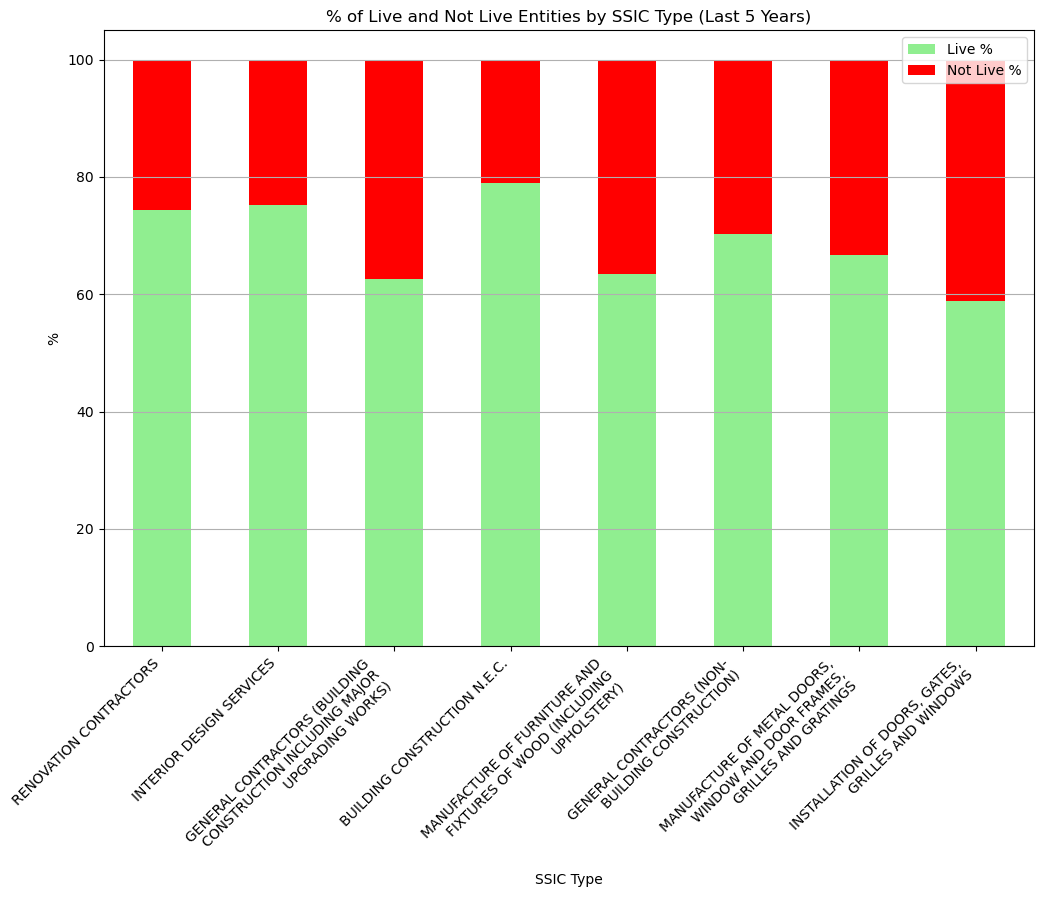

In [15]:
# Assuming acra_df contains your DataFrame
# Filter data for the last 5 years
years_used = 5
acra_since_x_years = acra_df[acra_df['acra_years_live'] == years_used]
acra_since_x_years = acra_since_x_years[acra_since_x_years['acra_primary_ssic_description'].isin(pri_more_20)]

# Group data by SSIC type and entity status, and calculate counts
grouped_data = acra_since_x_years.groupby(['acra_primary_ssic_description', 'acra_entity_status_bucket']).size().unstack(fill_value=0)

# Select only the last 10 years
grouped_data_last_x_years = grouped_data.groupby(level=0).sum()

# Create DataFrame for stacked bar chart
stacked_data_last_x_years = grouped_data_last_x_years.copy()
stacked_data_last_x_years['Total'] = stacked_data_last_x_years['Live'] + stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']
stacked_data_last_x_years['Not Live'] = stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']

# Calculate the percentage of not live entities
stacked_data_last_x_years['Live %'] = stacked_data_last_x_years['Live'] / stacked_data_last_x_years['Total'] * 100
stacked_data_last_x_years['Not Live %'] = (stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']) / stacked_data_last_x_years['Total'] * 100

print(stacked_data_last_x_years)

# Plot stacked bar chart
stacked_data_last_x_years[['Live %', 'Not Live %']].plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightgreen','red'])

# Add labels and title
plt.title(f'% of Live and Not Live Entities by SSIC Type (Last {years_used} Years)')
plt.xlabel('SSIC Type')
plt.ylabel('%')
plt.legend(['Live %', 'Not Live %'])

tick_labels = [textwrap.fill(label, width=30) for label in pri_more_20]
plt.xticks(range(len(pri_more_20)), tick_labels, rotation=45, ha='right')
plt.grid(axis='y')
# Show plot
plt.show()

acra_entity_status_bucket                           Live  No Status  Others  \
acra_primary_ssic_description                                                 
BUILDING CONSTRUCTION N.E.C.                         209         14     200   
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCL...   489         32     525   
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)      127         17     213   
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS      8          2      12   
INTERIOR DESIGN SERVICES                             259         36     519   
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (...    45          5      35   
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRA...    15          3       9   
RENOVATION CONTRACTORS                               290         26     412   

acra_entity_status_bucket                           Total  Not Live  \
acra_primary_ssic_description                                         
BUILDING CONSTRUCTION N.E.C.                          423       214

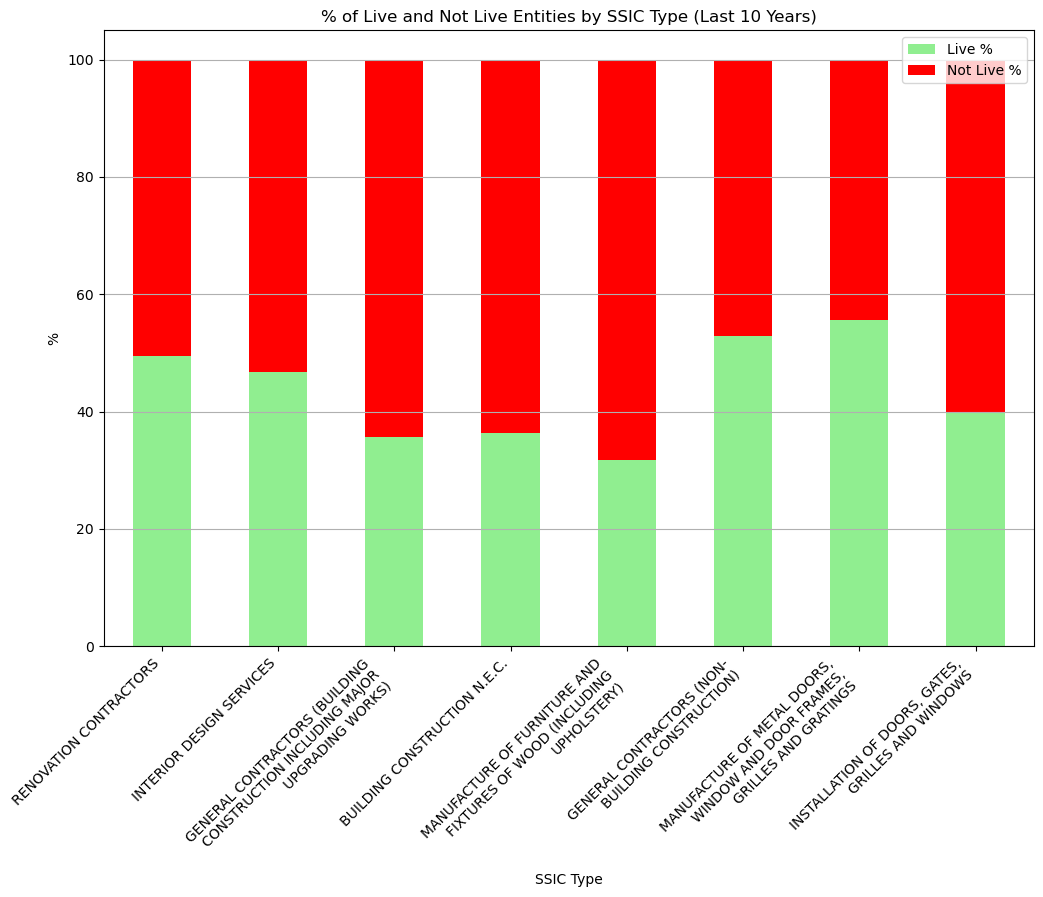

In [16]:
# Assuming acra_df contains your DataFrame
# Filter data for the last 10 years
years_used = 10
acra_since_x_years = acra_df[acra_df['acra_years_live'] == years_used]
acra_since_x_years = acra_since_x_years[acra_since_x_years['acra_primary_ssic_description'].isin(pri_more_20)]

# Group data by SSIC type and entity status, and calculate counts
grouped_data = acra_since_x_years.groupby(['acra_primary_ssic_description', 'acra_entity_status_bucket']).size().unstack(fill_value=0)

# Select only the last 10 years
grouped_data_last_x_years = grouped_data.groupby(level=0).sum()

# Create DataFrame for stacked bar chart
stacked_data_last_x_years = grouped_data_last_x_years.copy()
stacked_data_last_x_years['Total'] = stacked_data_last_x_years['Live'] + stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']
stacked_data_last_x_years['Not Live'] = stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']

# Calculate the percentage of not live entities
stacked_data_last_x_years['Live %'] = stacked_data_last_x_years['Live'] / stacked_data_last_x_years['Total'] * 100
stacked_data_last_x_years['Not Live %'] = (stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']) / stacked_data_last_x_years['Total'] * 100

print(stacked_data_last_x_years)

# Plot stacked bar chart
stacked_data_last_x_years[['Live %', 'Not Live %']].plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightgreen','red'])

# Add labels and title
plt.title(f'% of Live and Not Live Entities by SSIC Type (Last {years_used} Years)')
plt.xlabel('SSIC Type')
plt.ylabel('%')
plt.legend(['Live %', 'Not Live %'])

tick_labels = [textwrap.fill(label, width=30) for label in pri_more_20]
plt.xticks(range(len(pri_more_20)), tick_labels, rotation=45, ha='right')
plt.grid(axis='y')
# Show plot
plt.show()

acra_entity_status_bucket                           Live  No Status  Others  \
acra_primary_ssic_description                                                 
BUILDING CONSTRUCTION N.E.C.                         136         68     281   
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCL...   106         43     204   
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)       30         24      90   
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS      0          0       1   
INTERIOR DESIGN SERVICES                              80         50     291   
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (...    22         14      48   
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRA...    15          6      14   
RENOVATION CONTRACTORS                                90         86     268   

acra_entity_status_bucket                           Total  Not Live  \
acra_primary_ssic_description                                         
BUILDING CONSTRUCTION N.E.C.                          485       349

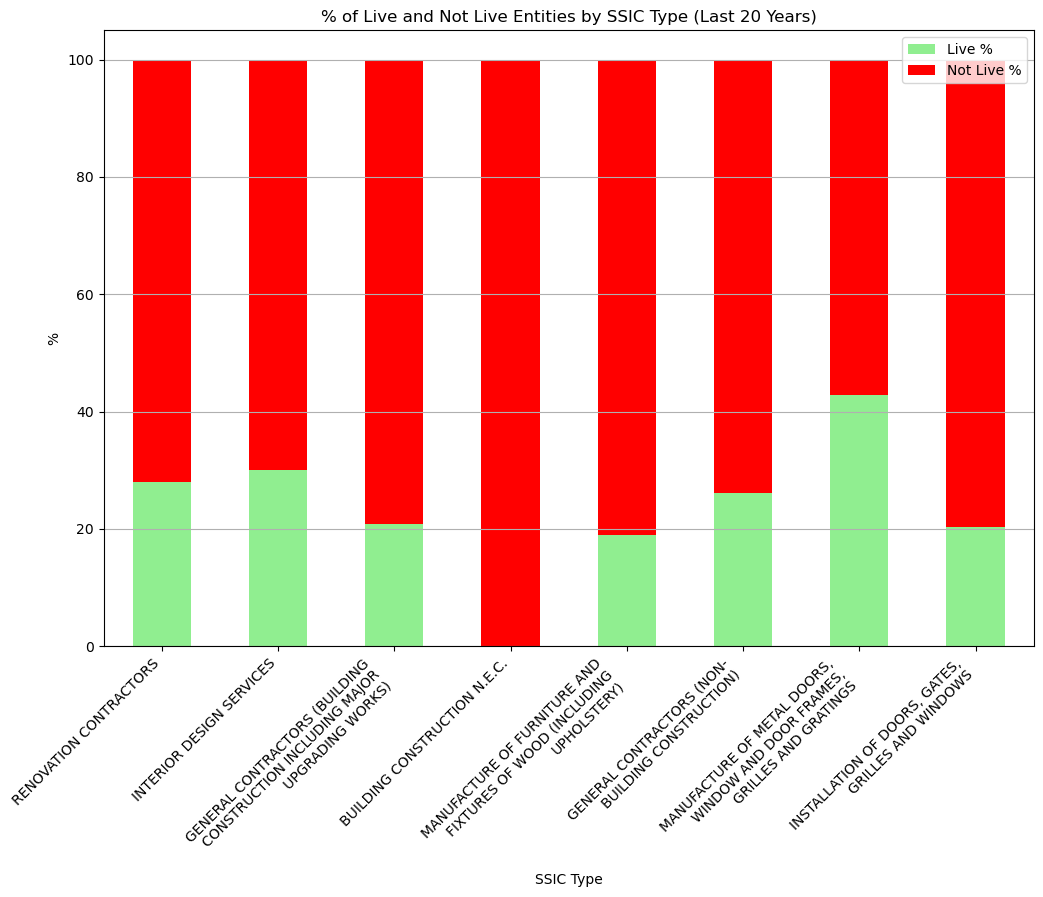

In [17]:
# Assuming acra_df contains your DataFrame
# Filter data for the last 20 years
years_used = 20
acra_since_x_years = acra_df[acra_df['acra_years_live'] == years_used]
acra_since_x_years = acra_since_x_years[acra_since_x_years['acra_primary_ssic_description'].isin(pri_more_20)]

# Group data by SSIC type and entity status, and calculate counts
grouped_data = acra_since_x_years.groupby(['acra_primary_ssic_description', 'acra_entity_status_bucket']).size().unstack(fill_value=0)

# Select only the last 10 years
grouped_data_last_x_years = grouped_data.groupby(level=0).sum()

# Create DataFrame for stacked bar chart
stacked_data_last_x_years = grouped_data_last_x_years.copy()
stacked_data_last_x_years['Total'] = stacked_data_last_x_years['Live'] + stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']
stacked_data_last_x_years['Not Live'] = stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']

# Calculate the percentage of not live entities
stacked_data_last_x_years['Live %'] = stacked_data_last_x_years['Live'] / stacked_data_last_x_years['Total'] * 100
stacked_data_last_x_years['Not Live %'] = (stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']) / stacked_data_last_x_years['Total'] * 100

print(stacked_data_last_x_years)

# Plot stacked bar chart
stacked_data_last_x_years[['Live %', 'Not Live %']].plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightgreen','red'])

# Add labels and title
plt.title(f'% of Live and Not Live Entities by SSIC Type (Last {years_used} Years)')
plt.xlabel('SSIC Type')
plt.ylabel('%')
plt.legend(['Live %', 'Not Live %'])

tick_labels = [textwrap.fill(label, width=30) for label in pri_more_20]
plt.xticks(range(len(pri_more_20)), tick_labels, rotation=45, ha='right')
plt.grid(axis='y')
# Show plot
plt.show()

acra_entity_status_bucket                           Live  No Status  Others  \
acra_primary_ssic_description                                                 
BUILDING CONSTRUCTION N.E.C.                         104        285     402   
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCL...    56        215     321   
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)        9         52      41   
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS      1          0       0   
INTERIOR DESIGN SERVICES                              15        136     167   
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (...    17        100      74   
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRA...     7         58      40   
RENOVATION CONTRACTORS                                58        327     303   

acra_entity_status_bucket                           Total  Not Live  \
acra_primary_ssic_description                                         
BUILDING CONSTRUCTION N.E.C.                          791       687

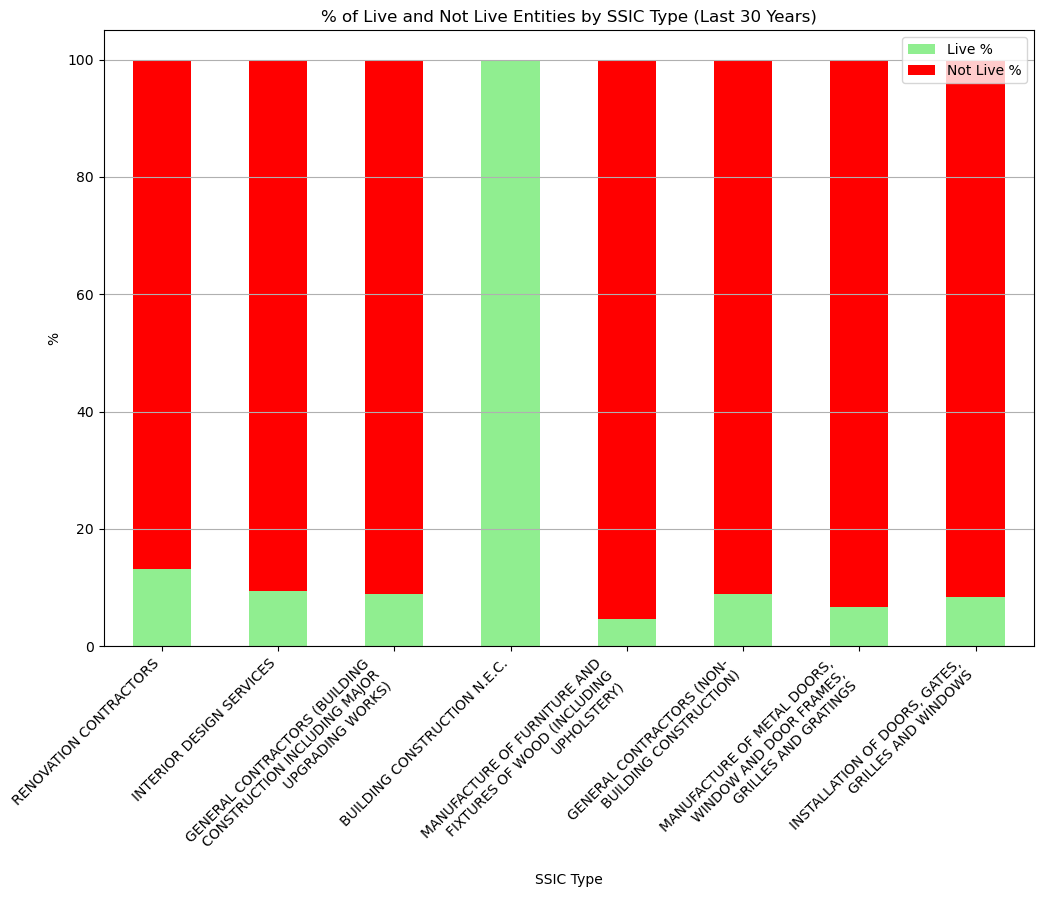

In [18]:
# Assuming acra_df contains your DataFrame
# Filter data for the last 20 years
years_used = 30
acra_since_x_years = acra_df[acra_df['acra_years_live'] == years_used]
acra_since_x_years = acra_since_x_years[acra_since_x_years['acra_primary_ssic_description'].isin(pri_more_20)]

# Group data by SSIC type and entity status, and calculate counts
grouped_data = acra_since_x_years.groupby(['acra_primary_ssic_description', 'acra_entity_status_bucket']).size().unstack(fill_value=0)

# Select only the last 10 years
grouped_data_last_x_years = grouped_data.groupby(level=0).sum()

# Create DataFrame for stacked bar chart
stacked_data_last_x_years = grouped_data_last_x_years.copy()
stacked_data_last_x_years['Total'] = stacked_data_last_x_years['Live'] + stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']
stacked_data_last_x_years['Not Live'] = stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']

# Calculate the percentage of not live entities
stacked_data_last_x_years['Live %'] = stacked_data_last_x_years['Live'] / stacked_data_last_x_years['Total'] * 100
stacked_data_last_x_years['Not Live %'] = (stacked_data_last_x_years['No Status'] + stacked_data_last_x_years['Others']) / stacked_data_last_x_years['Total'] * 100

print(stacked_data_last_x_years)

# Plot stacked bar chart
stacked_data_last_x_years[['Live %', 'Not Live %']].plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightgreen','red'])

# Add labels and title
plt.title(f'% of Live and Not Live Entities by SSIC Type (Last {years_used} Years)')
plt.xlabel('SSIC Type')
plt.ylabel('%')
plt.legend(['Live %', 'Not Live %'])

tick_labels = [textwrap.fill(label, width=30) for label in pri_more_20]
plt.xticks(range(len(pri_more_20)), tick_labels, rotation=45, ha='right')
plt.grid(axis='y')
# Show plot
plt.show()

# SSIC / % Not Live

In [19]:
pri_condition = acra_df['acra_primary_ssic_description'].isin(pri_more_20)
primary_ssic_description_hdb = acra_df[pri_condition]

# Calculate counts for each category
stacked_data = primary_ssic_description_hdb.groupby(['acra_year_incorporated', 'acra_entity_status_bucket']).size().unstack(fill_value=0)
print(stacked_data)
print()
stacked_data_filtered = stacked_data[stacked_data.index >= 1990].sort_index(ascending=False)
new_stacked_data = stacked_data_filtered.copy()
new_stacked_data['Total'] = new_stacked_data['Live'] + new_stacked_data['No Status'] + new_stacked_data['Others']
new_stacked_data['Not Live %'] = 100 - (new_stacked_data['Live'] / new_stacked_data['Total'] * 100)
print(new_stacked_data)

acra_entity_status_bucket  Live  No Status  Others
acra_year_incorporated                            
1889                          0          0       1
1917                          1          0       0
1936                          0          0       1
1938                          0          0       1
1940                          1          0       0
...                         ...        ...     ...
2020                       1708          4     649
2021                       2500         11     565
2022                       2810          4     394
2023                       3191          5     146
2024                        414          1       5

[82 rows x 3 columns]

acra_entity_status_bucket  Live  No Status  Others  Total  Not Live %
acra_year_incorporated                                               
2024                        414          1       5    420    1.428571
2023                       3191          5     146   3342    4.518253
2022                       2810  

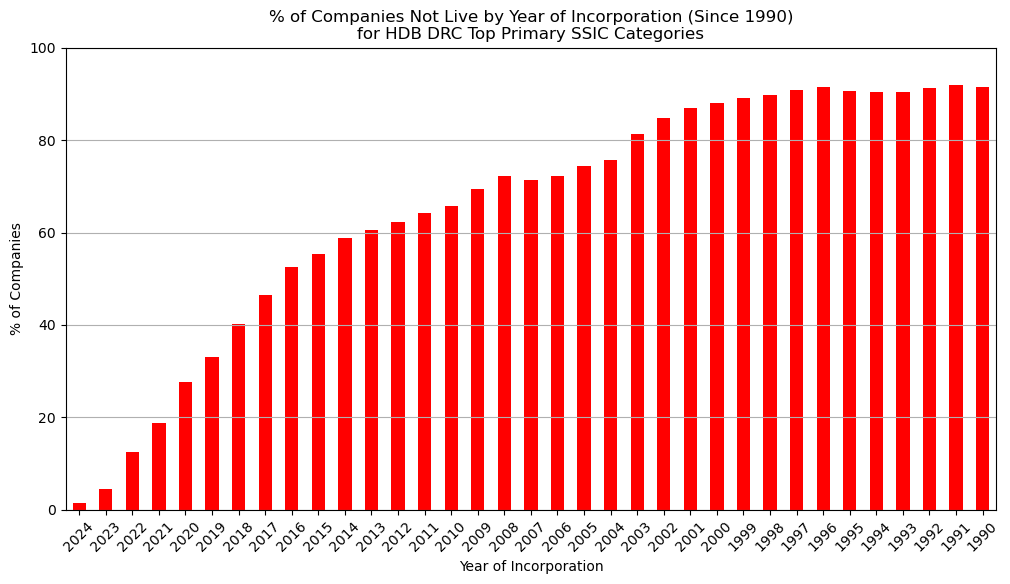

In [20]:
# Plotting the total counts for each year of incorporation
plt.figure(figsize=(12, 6))
new_stacked_data['Not Live %'].plot(kind='bar', color='red')
plt.title('% of Companies Not Live by Year of Incorporation (Since 1990)\nfor HDB DRC Top Primary SSIC Categories')
plt.xlabel('Year of Incorporation')
plt.ylabel('% of Companies')
plt.ylim(0,100)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Info about ACRA Dataset (for Live Companies only)

In [21]:
acra_live = acra_df[acra_df['acra_entity_status_bucket']=='Live']

In [22]:
entity_type = acra_live['acra_entity_type_description'].fillna('No Entity Type').value_counts()
print(entity_type)

Local Company    416549
Business         143204
LLP               16595
LP                  719
PAF                 466
Name: acra_entity_type_description, dtype: int64


In [23]:
business_constitution = acra_live['acra_business_constitution_description'].fillna('No Description').value_counts()
print(business_constitution)

No Description     433863
Sole Proprietor    126357
Partnership         17313
Name: acra_business_constitution_description, dtype: int64


In [24]:
entity_status = acra_live['acra_entity_status_description'].fillna('No Status').value_counts()
print(entity_status)

Live Company                                         413559
Live                                                 157721
Converted To LLP                                       3977
Amalgamated                                            2167
Live (Receiver or Receiver and Manager appointed)       109
Name: acra_entity_status_description, dtype: int64


1      67280
2      53362
3      48372
4      38753
5      35876
       ...  
120        1
102        1
114        1
115        1
101        1
Name: acra_years_live, Length: 111, dtype: int64


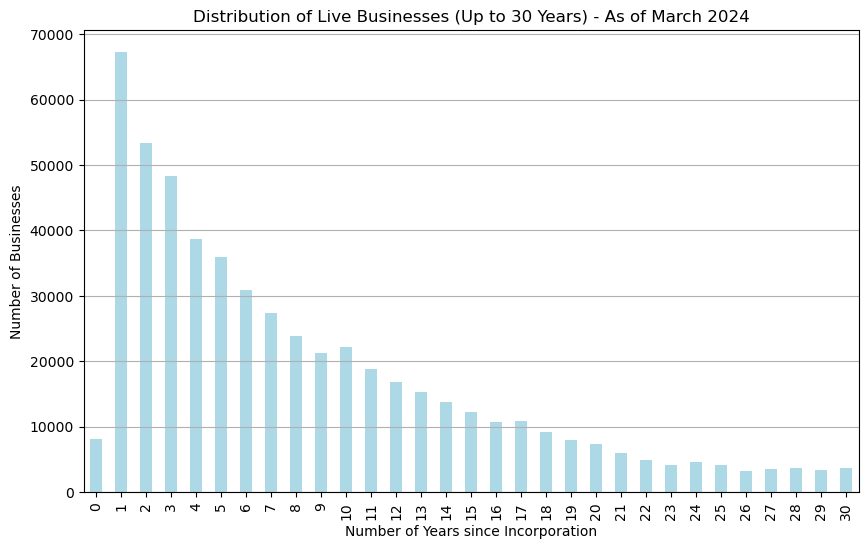

In [25]:
years_live = acra_live['acra_years_live'].fillna('No Status').value_counts()
print(years_live)
# Plotting the bar chart with x-axis in ascending order
years_live_filtered = years_live[years_live.index <= 30]
plt.figure(figsize=(10, 6))
years_live_filtered_sorted = years_live_filtered.sort_index()  # Sort the Series by index (number of years)
years_live_filtered_sorted.plot(kind='bar', color='lightblue')
plt.title('Distribution of Live Businesses (Up to 30 Years) - As of March 2024')
plt.xlabel('Number of Years since Incorporation')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=90)

# Adding count numbers on top of the bars
ax = plt.gca()
plt.grid(axis='y')
plt.show()

6 - 10 Years          127551
2 - 5 Years           125787
10 - 20 Years         125341
Less than 2 years     120559
More than 20 Years     78295
Name: acra_years_bucket, dtype: int64


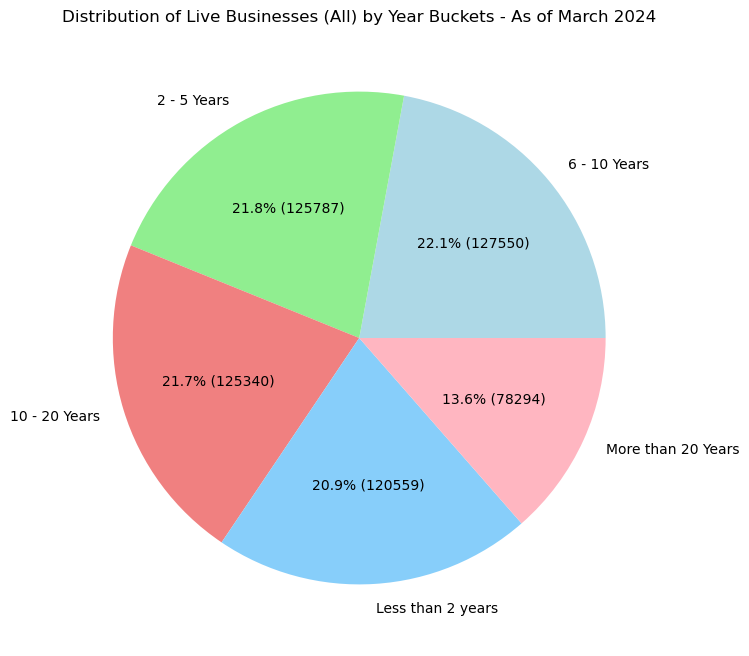

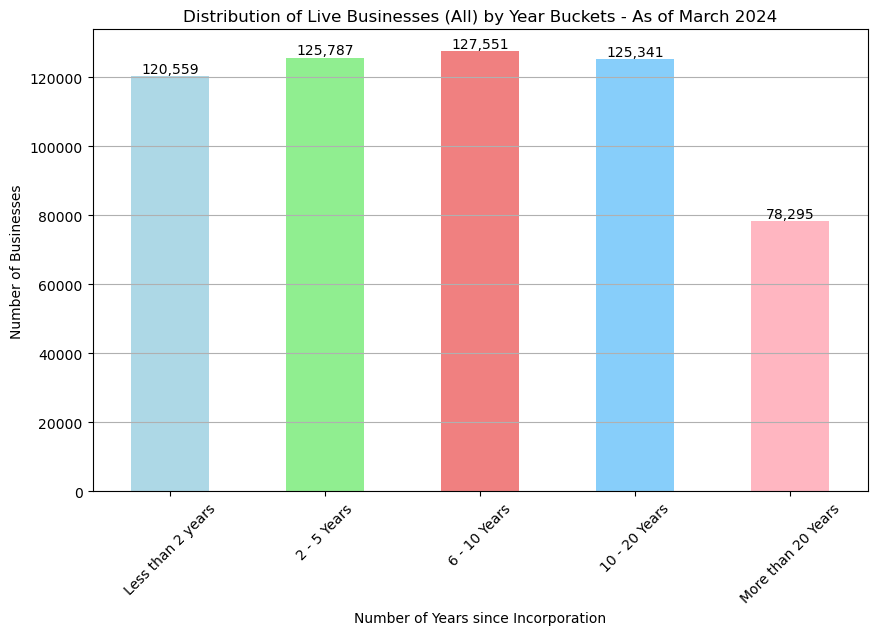

In [26]:
years_bucket = acra_live['acra_years_bucket'].fillna('No Status').value_counts()
print(years_bucket)
# Plotting the pie chart
plt.figure(figsize=(8, 8))
pie_chart = years_bucket.plot(kind='pie', autopct=lambda p:f'{p:.1f}% ({int(p/100*years_bucket.sum())})', colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink'])
plt.title('Distribution of Live Businesses (All) by Year Buckets - As of March 2024')
plt.ylabel('')
plt.show()

# Plotting the bar chart with custom x-axis order
plt.figure(figsize=(10, 6))
years_bucket = years_bucket.reindex(['Less than 2 years', '2 - 5 Years', '6 - 10 Years', '10 - 20 Years', 'More than 20 Years'])
ax = years_bucket.plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink'])
plt.title('Distribution of Live Businesses (All) by Year Buckets - As of March 2024')
plt.xlabel('Number of Years since Incorporation')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45)
plt.grid(axis='y')
# Adding count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [27]:
pri_condition_live = acra_live['acra_primary_ssic_description']
primary_ssic_description_live = acra_live['acra_primary_ssic_description'].value_counts()
print(primary_ssic_description_live)

WHOLESALE TRADE OF A VARIETY OF GOODS WITHOUT A DOMINANT PRODUCT                  55131
OTHER HOLDING COMPANIES                                                           52323
MANAGEMENT CONSULTANCY SERVICES                                                   38923
DEVELOPMENT OF SOFTWARE AND APPLICATIONS (EXCEPT GAMES AND CYBERSECURITY)         16355
INFORMATION TECHNOLOGY CONSULTANCY (EXCEPT CYBERSECURITY)                         10194
                                                                                  ...  
GOAT FARMS (INCLUDING GOAT'S MILK PRODUCTION)                                         1
PRIVATE DEBT FUNDS                                                                    1
PRODUCTION OF PREFABRICATED PREFINISHED VOLUMETRIC CONSTRUCTION (PPVC) MODULES        1
FROG FARMS                                                                            1
OTHER EXTRA-TERRITORIAL ORGANISATIONS AND BODIES                                      1
Name: acra_primary_ssic_descript

In [28]:
# Rank the primary_ssic_description_live Series based on counts
ranked_primary_ssic_description_live = primary_ssic_description_live.rank(method='first', ascending=False)

# Convert the ranked Series to a DataFrame
ranked_df = pd.DataFrame({'Count': primary_ssic_description_live, 'Rank': ranked_primary_ssic_description_live})

# Assuming your list is named 'your_list'
# Filter the DataFrame to include only items from your list
filtered_df = ranked_df.loc[pri_more_20]

# Print the filtered DataFrame
print(filtered_df)

                                                    Count   Rank
RENOVATION CONTRACTORS                               7222   10.0
INTERIOR DESIGN SERVICES                             5811   13.0
GENERAL CONTRACTORS (BUILDING CONSTRUCTION INCL...   9583    6.0
BUILDING CONSTRUCTION N.E.C.                         6142   12.0
MANUFACTURE OF FURNITURE AND FIXTURES OF WOOD (...   1455   67.0
GENERAL CONTRACTORS (NON-BUILDING CONSTRUCTION)      3065   29.0
MANUFACTURE OF METAL DOORS, WINDOW AND DOOR FRA...    434  217.0
INSTALLATION OF DOORS, GATES, GRILLES AND WINDOWS     219  324.0
